# From Notebook to CLI

> #### Exercise: From Notebook to CLI
>
> Your favorite Data Scientist created a model that can predict outcome types.
>
> * Take the relevant parts from 'Loading data' and 'Training a model' and use it to fill the function `train()` in `src/animal_shelter/cli.py
> * Take the relevant parts from 'Making predictions' and create a new command `predict` with:
>  * input: `--input_path`: path with the CSV to create preditions for.
>  * input: `--model_path`: path to the model saved with `train`.
>  * output: `--output_path`: path to output CSV with predictions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn 
import pandas as pd

from animal_shelter import data

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

%matplotlib inline

## Loading data

Load the train data.

In [3]:
train = data.load_data('../data/train.csv')

train.head()

,animal_id,name,date_time,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,Unknown,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,Unknown,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,Unknown,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## Exploratory Data Analysis

No nulls in the train set.
This makes our lives easier!

In [4]:
train.isnull().any()

animal_id           False
name                False
date_time           False
outcome_type        False
outcome_subtype     False
animal_type         False
sex_upon_outcome    False
age_upon_outcome    False
breed               False
color               False
dtype: bool

Cats are (in absolute numbers) transferred more often. Adopted animals were often 'fixed'.

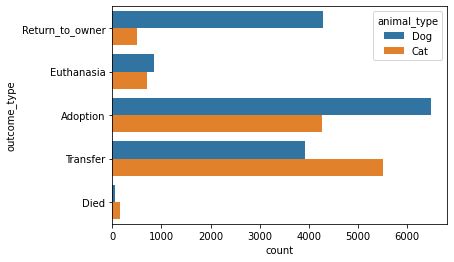

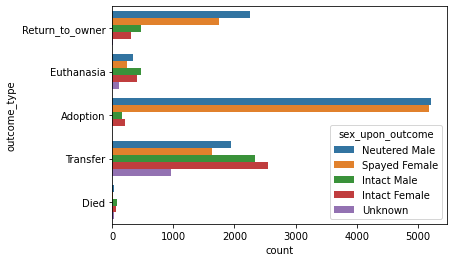

In [5]:
for col in ['animal_type', 'sex_upon_outcome']:
    fig, ax = plt.subplots()
    sns.countplot(y='outcome_type', hue=col, data=train, ax=ax)

Animals with age know were more often returned to their owners:

In [6]:
(
    train
    .assign(has_known_age=lambda x: x['age_upon_outcome'].str.contains('year'))
    .pivot_table('animal_id', 'has_known_age', 'outcome_type', aggfunc='nunique')
)

outcome_type,Adoption,Died,Euthanasia,Return_to_owner,Transfer
has_known_age,,,,,
False,5740,138,371,513,5124
True,5029,59,1184,4273,4298


## Training a model

Let's see if we can train a model!

### Split train and test set

In [7]:
X = train.drop('outcome_type', axis=1)
y = train['outcome_type']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

### Baseline

Naively select some columns of `X` and dummify them:

In [9]:
simple_cols = ['animal_type', 'sex_upon_outcome']

X_train_dummies = pd.get_dummies(X_train.loc[:, simple_cols])

We'll use `cross_val_score` to quickly get a feeling for the cross validation score.

Get a baseline for all classes by randomly prediction with occurrence of the classes:

In [10]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

cross_val_score(DummyClassifier(), X_train_dummies,
                y_train, scoring='neg_log_loss', cv=5)

array([-1.24447376, -1.24428049, -1.24428049, -1.2443096 , -1.2443096 ])

### Model selection and hyperparameter tuning

What would logistic regression do?

In [11]:
from sklearn.linear_model import LogisticRegression

cross_val_score(LogisticRegression(C=0.1), X_train_dummies,
                y_train, scoring='neg_log_loss', cv=5)

array([-1.01672962, -0.98675013, -0.99423395, -1.01057328, -0.98880588])

Better than the baseline!

Let's find an optimal logistic regression model given these features.
We'll try to optimize regularization parameter $C$.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [1E-3, 1E-2, 1E-1]}
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring='neg_log_loss')

grid_search.fit(X_train_dummies, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1]}, scoring='neg_log_loss')

Our best score is:

In [13]:
grid_search.best_score_

-0.9994185711037128

The best parameter was:

In [14]:
grid_search.best_params_

{'C': 0.1}

Our best model is:

In [15]:
best_model = grid_search.best_estimator_

Save it:

In [16]:
joblib.dump(best_model, '../output/outcome_model.pickle')

['../output/outcome_model.pickle']

## Making predictions

Load the previous model and data that we want predictions for:

In [17]:
outcome_model = joblib.load('../output/outcome_model.pickle')
test = data.load_data('../data/test.csv')
X_test = test  # no y in there

Get predictions

In [18]:
X_pred_dummies = pd.get_dummies(X_test.loc[:, simple_cols])
y_pred = outcome_model.predict_proba(X_pred_dummies)

Get the classes and create a DataFrame with the probabilities:

In [19]:
classes = outcome_model.classes_.tolist()
classes

['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

In [20]:
proba_df = pd.DataFrame(y_pred, columns=classes)
proba_df.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,0.058266,0.009358,0.132124,0.170406,0.629845
1,0.533640,0.002048,0.028203,0.274888,0.161221
2,0.640451,0.005262,0.033676,0.060233,0.260378
3,0.045613,0.012201,0.149704,0.247365,0.545117
4,0.483589,0.002017,0.036612,0.304388,0.173393


Add the ID, reorder columns and save as CSV.:

In [21]:
proba_df['id'] = test['id']
reordered = proba_df[['id'] + classes]
reordered.to_csv('../output/predictions.csv', index=False)